# Model Loading - Part 1 (Practice Code)

In [1]:
!pip install -U -q onnxruntime-gpu

In [2]:
import os
import math
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt

In [3]:
os.chdir('../')

In [4]:
model_path = 'models/yolov8_5class_10percent/best.onnx'

## Reading the model

In [5]:
EP_LIST = ['CUDAExecutionProvider', 'CPUExecutionProvider']
ort_session = onnxruntime.InferenceSession(model_path, providers=EP_LIST)

In [6]:
# Model meta dataw
model_meta = ort_session.get_modelmeta()
classes = eval(model_meta.custom_metadata_map['names'])
num_classes = len(classes)
classes, num_classes

({0: 'chicken_curry',
  1: 'chocolate_cake',
  2: 'hamburger',
  3: 'pizza',
  4: 'ramen'},
 5)

In [7]:
# Model input details
model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_height = input_shape[2]
input_width = input_shape[3]

input_names, input_shape

(['images'], [1, 3, 512, 512])

In [8]:
# Model output details
model_outputs = ort_session.get_outputs()
output_names = [model_outputs[i].name for i in range(len(model_outputs))]
output_shape = [model_outputs[i].shape for i in range(len(model_outputs))]
output_names, output_shape

(['output0', 'output1'], [[1, 41, 5376], [1, 32, 128, 128]])

## Reading a Input Image

In [9]:
image_path = 'datasets/images/val/pizza/420409.jpg'

# Processing the input image
image = cv2.imread(image_path)
image_height, image_width = image.shape[:2]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(image_rgb, (input_width, input_height))

# Converting into yolo format
input_image = resized_img / 255.
input_image = input_image.transpose(2, 0, 1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 512, 512)

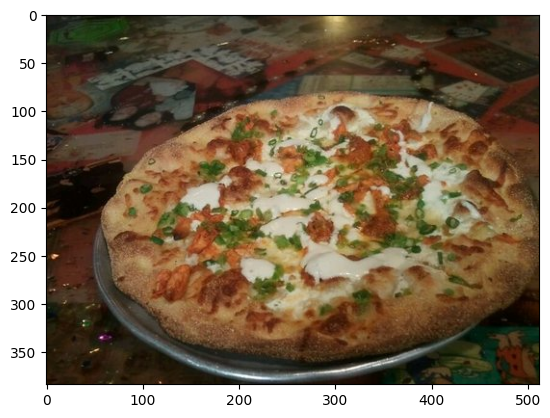

In [10]:
plt.imshow(image_rgb)

## Performing Inference

In [11]:
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})
outputs

[array([[[ 1.2208679e+01,  1.6776455e+01,  2.2360916e+01, ...,
           4.1772870e+02,  4.3623230e+02,  4.5346997e+02],
         [ 1.1720257e+01,  1.1909761e+01,  1.1621646e+01, ...,
           4.5210980e+02,  4.6315997e+02,  4.6469861e+02],
         [ 2.4291740e+01,  3.4127029e+01,  4.4735703e+01, ...,
           1.8475269e+02,  1.4943417e+02,  1.1759741e+02],
         ...,
         [-7.8594548e-01, -1.0672002e+00, -1.1837366e+00, ...,
           9.8559335e-02,  1.3206714e-01,  1.1348308e-01],
         [-6.1543310e-01, -7.6909608e-01, -6.7861718e-01, ...,
          -4.2122060e-01, -4.9124843e-01, -4.8305953e-01],
         [-1.2668903e-01, -6.5864660e-02, -1.9294770e-01, ...,
           3.7218499e-01,  3.7753817e-01,  3.8376594e-01]]], dtype=float32),
 array([[[[ 0.2796778 ,  0.2356508 ,  0.28099164, ...,  0.16187878,
            0.19123659,  0.15850328],
          [ 0.16596794,  0.13646482,  0.20389445, ...,  0.08014779,
            0.11369434,  0.07584374],
          [ 0.15363044, 

## Extracting Bounding Box Data from Inference Result

In [12]:
# Extracting bounding box
box_output = outputs[0]
num_masks = 32
predictions = np.squeeze(box_output).T
num_classes = box_output.shape[1] - num_masks - 4
box_output.shape, predictions.shape, num_classes

((1, 41, 5376), (5376, 41), 5)

In [13]:
# Filter out object confidence score below threshold
conf_threshold = 0.7
scores = np.max(predictions[:, 4: 4+num_classes], axis=1)
predictions = predictions[scores > conf_threshold, :]
scores = scores[scores > conf_threshold]
scores

array([0.81659824, 0.8582697 , 0.87865037, 0.88625413, 0.90407574,
       0.92266905, 0.91871625, 0.7017105 , 0.89495105, 0.8421841 ],
      dtype=float32)

In [14]:
# Getting the predicted class
box_predictions = predictions[..., :num_classes+4]
mask_predictions = predictions[..., num_classes+4:]
class_ids = np.argmax(box_predictions[:, 4:], axis=1)
box_predictions, class_ids

(array([[2.7135107e+02, 2.9767859e+02, 4.7634311e+02, 3.9652795e+02,
         1.2743473e-04, 3.5762787e-06, 7.1406364e-05, 8.1659824e-01,
         3.5524368e-05],
        [2.8107062e+02, 2.9502924e+02, 4.4793875e+02, 3.8723987e+02,
         5.4359436e-05, 1.1920929e-06, 5.1379204e-05, 8.5826969e-01,
         6.6757202e-06],
        [2.7676947e+02, 2.9522900e+02, 4.6526013e+02, 3.8848569e+02,
         8.8930130e-05, 1.5497208e-06, 4.9591064e-05, 8.7865037e-01,
         9.2983246e-06],
        [2.6720993e+02, 2.9585416e+02, 4.8839575e+02, 3.8824945e+02,
         3.2496452e-04, 2.7418137e-06, 6.4253807e-05, 8.8625413e-01,
         3.2424927e-05],
        [2.7945267e+02, 2.9709927e+02, 4.4500623e+02, 3.7630286e+02,
         4.0549040e-04, 3.6954880e-06, 1.6069412e-04, 9.0407574e-01,
         1.8835068e-05],
        [2.7871606e+02, 2.9855472e+02, 4.5762317e+02, 3.7274066e+02,
         6.8664551e-04, 7.0333481e-06, 1.7327070e-04, 9.2266905e-01,
         3.2544136e-05],
        [2.6730423e+02

In [15]:
# Processing the bounding box
boxes = box_predictions[:, :4]

# Rescaling the box dimension
box_dim = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, box_dim, dtype=np.float32) # Normalizing the boxes
boxes *= np.array([image_width, image_height, image_width, image_height]) # boxes are rescaled with image dimension

# Converting the Yolo format to Pascal VOC
bbox = boxes.copy()
bbox[..., 0] = boxes[..., 0] - boxes[..., 2] / 2
bbox[..., 1] = boxes[..., 1] - boxes[..., 3] / 2
bbox[..., 2] = boxes[..., 0] + boxes[..., 2] / 2
bbox[..., 3] = boxes[..., 1] + boxes[..., 3] / 2

# Checking the box within the image dimension
bbox[:, 0] = np.clip(bbox[:, 0], 0, image_width)
bbox[:, 1] = np.clip(bbox[:, 1], 0, image_height)
bbox[:, 2] = np.clip(bbox[:, 2], 0, image_width)
bbox[:, 3] = np.clip(bbox[:, 3], 0, image_height)
bbox

array([[ 33.17952 ,  74.56096 , 509.52264 , 371.9569  ],
       [ 57.101242,  76.05698 , 505.03998 , 366.48688 ],
       [ 44.139404,  75.739624, 509.39954 , 367.10388 ],
       [ 23.012054,  76.29709 , 511.4078  , 367.48416 ],
       [ 56.949554,  81.71089 , 501.95578 , 363.93805 ],
       [ 49.90448 ,  84.138306, 507.52765 , 363.6938  ],
       [ 22.313293,  85.52408 , 512.      , 363.6658  ],
       [ 57.438416, 106.90785 , 501.6386  , 361.4956  ],
       [ 52.382202, 111.2112  , 507.4878  , 361.49854 ],
       [ 29.372131, 108.597824, 511.0271  , 361.49426 ]], dtype=float32)

In [16]:
# Performing NMS on the bounding box
# Creating a function for IoU
def compute_iou(box, boxes):
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])
    
    intersection_area = np.maximum(0, xmax-xmin) * np.maximum(0, ymax-ymin)
    
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

# Sorting the scores
sorted_indices = np.argsort(scores)[::-1]
keep_boxes = []
while sorted_indices.size > 0:
    # pick the last box
    box_id = sorted_indices[0]
    keep_boxes.append(box_id)
    
    # Compute IoU with rest of the boxes
    ious = compute_iou(bbox[box_id, :], bbox[sorted_indices[1:], :])
    
    # Remove box over threshold
    keep_indices = np.where(ious < 0.5)[0]
    sorted_indices = sorted_indices[keep_indices + 1]

indices = keep_boxes
indices

[5]

In [17]:
boxes = bbox[indices]
scores = scores[indices]
class_ids = class_ids[indices]
mask_predictions = mask_predictions[indices]
boxes, scores, class_ids, mask_predictions

(array([[ 49.90448 ,  84.138306, 507.52765 , 363.6938  ]], dtype=float32),
 array([0.92266905], dtype=float32),
 array([3]),
 array([[-0.9584718 ,  0.16046   ,  0.38330042, -0.5908772 , -0.07981233,
          0.37478906,  0.499353  ,  0.7143433 ,  0.45268252, -1.633199  ,
          0.18245131,  0.7313986 , -0.53976876,  0.20945963, -1.7155706 ,
          0.74397856, -0.0243464 ,  0.94199944, -1.0307033 ,  0.53261185,
          0.534945  , -0.42548442, -0.24213411,  0.3400853 ,  0.3033652 ,
          0.44138864, -0.34585378,  0.20440425, -0.28208983,  0.49963138,
         -0.14421168,  0.2969373 ]], dtype=float32))

## Extracting Mask Data from Inference Result

In [18]:
mask_output = np.squeeze(outputs[1])

# performing sigmoid on mask output
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

num_mask, mask_height, mask_width = mask_output.shape
masks = sigmoid(mask_predictions @ mask_output.reshape((num_mask, -1)))
masks = masks.reshape((-1, mask_height, mask_width))
masks, masks.shape

(array([[[0.46219042, 0.4018923 , 0.39843923, ..., 0.90249324,
          0.90616804, 0.8890851 ],
         [0.39971524, 0.34584096, 0.33747807, ..., 0.9432201 ,
          0.9432589 , 0.9186219 ],
         [0.46184626, 0.41825518, 0.39686677, ..., 0.945091  ,
          0.9459582 , 0.9213485 ],
         ...,
         [0.83953816, 0.8608847 , 0.8287068 , ..., 0.8609519 ,
          0.8197438 , 0.81094444],
         [0.82475585, 0.84594536, 0.8084198 , ..., 0.82840896,
          0.7606289 , 0.7611462 ],
         [0.7845465 , 0.7726503 , 0.7208081 , ..., 0.7557083 ,
          0.69951224, 0.7152846 ]]], dtype=float32),
 (1, 128, 128))

In [19]:
# Downscaling the boxes to match the mask size
box_dim = np.array([image_width, image_height, image_width, image_height])
scale_boxes = np.divide(boxes, box_dim, dtype=np.float32) # Denormalizing the boxes
scale_boxes *= np.array([mask_width, mask_height, mask_width, mask_height]) # boxes are rescaled with mask dimension
scale_boxes

array([[ 12.47612 ,  28.046103, 126.88191 , 121.23126 ]], dtype=float32)

In [20]:
# Getting the mask map for box/mask pair
mask_maps = np.zeros((len(scale_boxes), image_height, image_width))
blur_size = (int(image_width/mask_width), int(image_height/mask_height))

In [21]:
# Cropping the mask and adding it to the mask maps
for i in range(len(scale_boxes)):
    scale_x1 = int(math.floor(scale_boxes[i][0]))
    scale_y1 = int(math.floor(scale_boxes[i][1]))
    scale_x2 = int(math.floor(scale_boxes[i][2]))
    scale_y2 = int(math.floor(scale_boxes[i][3]))
    
    x1 = int(math.floor(boxes[i][0]))
    y1 = int(math.floor(boxes[i][1]))
    x2 = int(math.floor(boxes[i][2]))
    y2 = int(math.floor(boxes[i][3]))
    
    scale_crop_mask = masks[i][scale_y1:scale_y2, scale_x1:scale_x2]
    crop_mask = cv2.resize(scale_crop_mask, (x2-x1, y2-y1), interpolation=cv2.INTER_CUBIC)
    crop_mask = cv2.blur(crop_mask, blur_size)
    crop_mask = (crop_mask > 0.5).astype(np.uint8)
    mask_maps[i, y1:y2, x1:x2] = crop_mask

## Visualizing the Extracted Data

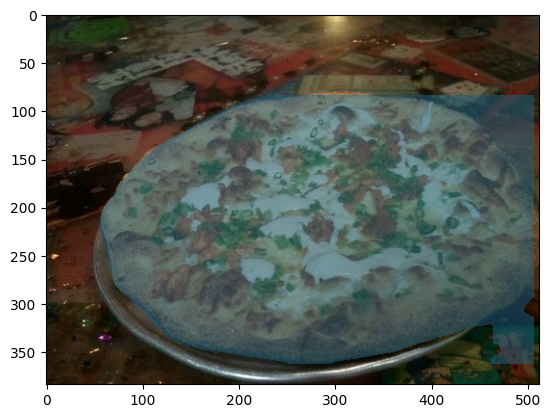

In [22]:
# Visualizing the mask on the image
mask_img = image_rgb.copy()

class_names = list(classes.values()) # list of the classes
rng = np.random.default_rng(3) 
colors = rng.uniform(0, 255, size=(len(class_names), 3)) # list of colors

# Draw bounding boxes and labels of detections
for i, (box, class_id) in enumerate(zip(boxes, class_ids)):
    color = colors[class_id]
    x1, y1, x2, y2 = box.astype(int)

    # Draw fill mask image
    if mask_maps is None:
        cv2.rectangle(mask_img, (x1, y1), (x2, y2), color, -1) # Fill rectangle
    else:
        crop_mask = mask_maps[i][y1:y2, x1:x2, np.newaxis] # cropping the mask
        crop_mask_img = mask_img[y1:y2, x1:x2] # Cropping the image of mask area
        crop_mask_img = crop_mask_img * (1 - crop_mask) + crop_mask * color # overlapping mask on the image
        mask_img[y1:y2, x1:x2] = crop_mask_img
masked_image_result = cv2.addWeighted(mask_img, 0.5, image_rgb, 1 - 0.5, 0) # Adding opacity on the image
plt.imshow(masked_image_result)

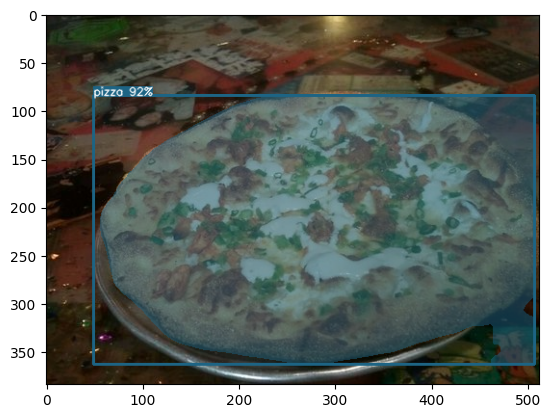

In [23]:
size = min([image_height, image_width]) * 0.001 # dynamic font scale
text_thickness = int(min([image_height, image_width]) * 0.001) # dynamic text thickness

# Draw bounding boxes and labels of detections
for box, score, class_id in zip(boxes, scores, class_ids):
    color = colors[class_id]
    x1, y1, x2, y2 = box.astype(int)
    
    # Draw rectangle
    cv2.rectangle(masked_image_result, (x1, y1), (x2, y2), color, 2) # Draws the box
    label = class_names[class_id] 
    caption = f'{label} {int(score * 100)}%'   
    (tw, th), _ = cv2.getTextSize(text=caption, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                  fontScale=size, thickness=text_thickness) # Get the text box size
    th = int(th * 1.2)
    cv2.rectangle(masked_image_result, (x1, y1),
                  (x1 + tw, y1-th if y1-10>0 else y1+10+th), color, -1) # Draw a box for text
    cv2.putText(masked_image_result, caption, (x1, y1 if y1-10>0 else y1+15), 
                cv2.FONT_HERSHEY_SIMPLEX, size, (255, 255, 255), text_thickness, cv2.LINE_AA) # Adding text
plt.imshow(masked_image_result)